# [West-Nile-Virus Kaggle Competition](https://www.kaggle.com/c/predict-west-nile-virus)

In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


From Kaggle:

> [West Nile virus](https://www.cdc.gov/westnile/) is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

> In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

> Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

> Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus. 

Tasks for this session will be to:

* Create preprocessing function to load weather data
* Create some features
* Create a better way to perform a test/train split
* Train some models

## Load in pre-processing functions

We will do a lot of pre-processing of the data and comibining with the weather dataset to produce a number of hopefully informative features for the task of predicting the presence of WNV.

In [2]:
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing
import os.path
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
from sklearn.neighbors import KernelDensity
import datetime

'''
Feature functions

'''



def convertColumnToWeeks(col):
    return np.floor((pd.to_datetime(col) - datetime.datetime(2007,01,01)).dt.days/7.).astype(int)


def addDateCol(df):
    '''
    add leaky feature to column
    '''
    print df.groupby('Date').count().columns
    dt_count = df.groupby('Date').count()[['Address']] #get mutiple counts on a certain date
    dt_count.columns = ['DateCount'] #create new column for how many times date repeated.
    test = pd.merge(df, dt_count, how='inner', left_on='Date', right_index=True)
    return test['DateCount']

'''

Load in data

'''

def loadPreData(features=False):
    """
        Beating the Benchmark
        West Nile Virus Prediction @ Kaggle
        __author__ : Abhihsek
    """
    # Load dataset
    train = pd.read_csv('./data/train.csv')
    test = pd.read_csv('./data/test.csv')
    sample = pd.read_csv('./data/sampleSubmission.csv')
    weather = pd.read_csv('./data/weather.csv')

    # Get labels
    labels = train.WnvPresent.values
    mosquitoes = train.NumMosquitos.values


    #add leaky feature
    train_datecount = addDateCol(train)
    test_datecount = addDateCol(test)

    # Not using codesum for this benchmark
    weather = weather.drop('CodeSum', axis=1)

    # Split station 1 and 2 and join horizontally
    weather_stn1 = weather[weather['Station']==1]
    weather_stn2 = weather[weather['Station']==2]
    weather_stn1 = weather_stn1.drop('Station', axis=1)
    weather_stn2 = weather_stn2.drop('Station', axis=1)
    weather = weather_stn1.merge(weather_stn2, on='Date')

    # replace some missing values and T with -1
    weather = weather.replace('M', -1)
    weather = weather.replace('-', -1)
    weather = weather.replace('T', -1)
    weather = weather.replace(' T', -1)
    weather = weather.replace('  T', -1)


    
    train['day'] = pd.to_datetime(train['Date']).dt.day
    train['month'] = pd.to_datetime(train['Date']).dt.month
    train['year'] = pd.to_datetime(train['Date']).dt.year
    
    test['day'] = pd.to_datetime(test['Date']).dt.day
    test['month'] = pd.to_datetime(test['Date']).dt.month
    test['year'] = pd.to_datetime(test['Date']).dt.year   
    
    #add column for number of weeks since start of monitoring
    train['weeks_since_start'] = convertColumnToWeeks(train['Date'])
    test['weeks_since_start'] = convertColumnToWeeks(test['Date'])

    # Add integer latitude/longitude columns
    train['Lat_int'] = train.Latitude.apply(int)
    train['Long_int'] = train.Longitude.apply(int)
    test['Lat_int'] = test.Latitude.apply(int)
    test['Long_int'] = test.Longitude.apply(int)

    # drop address columns
    train = train.drop(['Address', 'AddressNumberAndStreet','WnvPresent', 'NumMosquitos'], axis = 1)
    test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

    # Merge with weather data
    train = train.merge(weather, on='Date')
    test = test.merge(weather, on='Date')
    train = train.drop(['Date'], axis = 1)
    test = test.drop(['Date'], axis = 1)

    # Convert categorical data to numbers
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train['Species'].values) + list(test['Species'].values))
    train['Species'] = lbl.transform(train['Species'].values)
    test['Species'] = lbl.transform(test['Species'].values)

    lbl.fit(list(train['Street'].values) + list(test['Street'].values))
    train['Street'] = lbl.transform(train['Street'].values)
    test['Street'] = lbl.transform(test['Street'].values)

    lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
    train['Trap'] = lbl.transform(train['Trap'].values)
    test['Trap'] = lbl.transform(test['Trap'].values)

    # drop columns with -1s
    train = train.ix[:,(train != -1).any(axis=0)]
    test = test.ix[:,(test != -1).any(axis=0)]

    #add leaky feature
    train['DateCount'] = train_datecount
    test['DateCount'] = test_datecount
    

    
    if features:
        train,test = loadFeatures(train,test)



    return {'train':train,'test':test,'labels':labels,'num_mosquitoes':mosquitoes}

## Load in test and train datasets

In [3]:
data = loadPreData(features=False)
train = data['train']
test = data['test']
wnv_labels = data['labels']

Index([u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent'],
      dtype='object')
Index([u'Id', u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy'],
      dtype='object')


### Check columns for train data

In [45]:
train.head()

,Species,Block,Street,Trap,Latitude,Longitude,AddressAccuracy,day,month,year,...,WetBulb_y,Heat_y,Cool_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y,DateCount
0,2,41,36,1,41.954690,-87.800991,9,29,5,2007,...,66,0,12,0.00,29.44,30.09,5.8,16,7.4,25
1,3,41,36,1,41.954690,-87.800991,9,29,5,2007,...,66,0,12,0.00,29.44,30.09,5.8,16,7.4,25
2,3,62,30,8,41.994991,-87.769279,9,29,5,2007,...,66,0,12,0.00,29.44,30.09,5.8,16,7.4,25
3,2,79,120,15,41.974089,-87.824812,8,29,5,2007,...,66,0,12,0.00,29.44,30.09,5.8,16,7.4,25
4,3,79,120,15,41.974089,-87.824812,8,29,5,2007,...,66,0,12,0.00,29.44,30.09,5.8,16,7.4,25


# Feature engineering
___

In this section we'll explore some aspects of the data to try and engineer some informative features. For example, some locations in Chicago might be more pre-disposed to having a large number of mosquitoes, which would imply the presence of WNV. We would then construct a feature that takes into account historic prevalence of WNV to take advantage of this. Other features come about due to the nature of how the data was constructed. This is referred to as data leakage.

## Data leak

![img](https://i2.wp.com/www.gotmold.ca/wp-content/uploads/2015/10/how-to-stop-water-leaks-in-brick-home.jpg?resize=690%2C462&ssl=1)

Kaggle defines [leakage](https://www.kaggle.com/wiki/Leakage) as

> Data Leakage is the creation of unexpected additional information in the training data, allowing a model or machine learning algorithm to make unrealistically good predictions.

Some examples given by kaggle include

> One concrete example we've seen occurred in a prostrate cancer dataset. Hidden among hundreds of variables in the training data was a variable named PROSSURG. It turned out this represented whether the patient had received prostate surgery, an incredibly predictive but out-of-scope value.

> The resulting model was highly predictive of whether the patient had prostate cancer but was useless for making predictions on new patients.

> This is an extreme example - many more instances of leakage occur in subtle and hard-to-detect ways. An early Kaggle competition, Link Prediction for Social Networks, makes a good case study in this.

> There was a sampling error in the script that created that dataset for the competition: a > sign instead of a >= sign meant that, when a candidate edge pair had a certain property, the edge pair was guaranteed to be true. A team exploited this leakage to take second in the competition.

> Furthermore, the winning team won not by using the best machine-learned model, but by scraping the underlying true social network and then defeated anonymization of the nodes with a very clever methodology.

> Outside of Kaggle, we've heard war stories of models with leakage running in production systems for years before the bugs in the data creation or model training scripts were detected.

Our model is no exception. From last time we found the following lines of code allowed us to score a respectable 0.71 AUC score:

```python

    dt_count = df.groupby('Date').count()[['Address']] #get mutiple counts on a certain date
    dt_count.columns = ['DateCount'] #create new column for how many times date repeated.
    test = pd.merge(df, dt_count, how='inner', left_on='Date', right_index=True)
    cnt_pred = np.array(res_df['DateCount'])
    cnt_pred = 1.0*(cnt_pred - cnt_pred.min()) / (cnt_pred.max() - cnt_pred.min()) #normalize value to get prob.

```

We'll explore a few other potential ideas for informative features


## Geographic presence of WNV feature



IDEA: if mosquitos are nearby then west-nile virus is 
    likely being transmitted

In [5]:
from sklearn.neighbors import KernelDensity

In [12]:
test.columns

Index([u'Species', u'Block', u'Street', u'Trap', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'month', u'day', u'Lat_int', u'Long_int',
       u'Tmax_x', u'Tmin_x', u'Tavg_x', u'Depart_x', u'DewPoint_x',
       u'WetBulb_x', u'Heat_x', u'Cool_x', u'Sunrise_x', u'Sunset_x',
       u'Depth_x', u'SnowFall_x', u'PrecipTotal_x', u'StnPressure_x',
       u'SeaLevel_x', u'ResultSpeed_x', u'ResultDir_x', u'AvgSpeed_x',
       u'Tmax_y', u'Tmin_y', u'Tavg_y', u'DewPoint_y', u'WetBulb_y', u'Heat_y',
       u'Cool_y', u'PrecipTotal_y', u'StnPressure_y', u'SeaLevel_y',
       u'ResultSpeed_y', u'ResultDir_y', u'AvgSpeed_y', u'DateCount'],
      dtype='object')

In [14]:
Xs = train[wnv_labels==1][['Longitude','Latitude']].get_values()
kde = KernelDensity(bandwidth=0.02, 
                    kernel='gaussian')
kde.fit(Xs)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.02, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

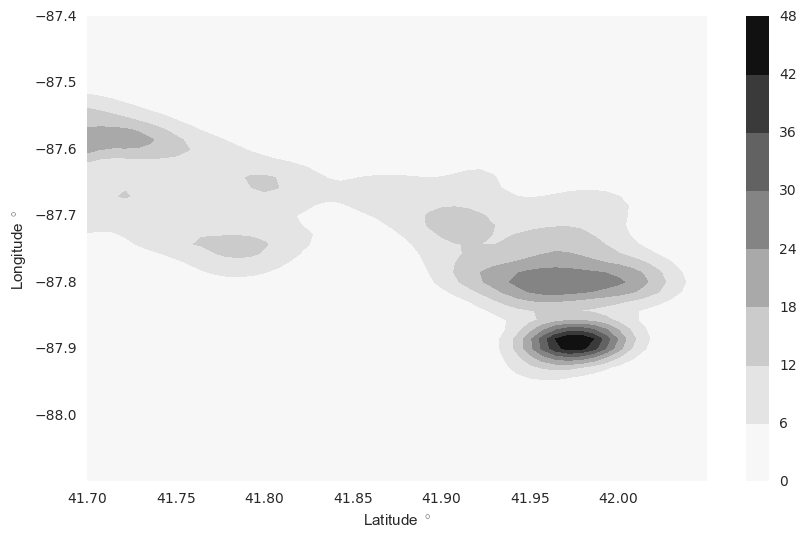

In [19]:
plt.figure(figsize=(10,6));
Y,X = np.meshgrid(np.linspace(-88.1,-87.4),np.linspace(41.7,42.05))
xy = np.vstack([Y.ravel(), X.ravel()]).T
scores = np.exp(kde.score_samples(xy)).reshape(X.shape)

plt.contourf(X, Y, scores);
plt.xlabel('Latitude $^\circ$');
plt.ylabel('Longitude $^\circ$');
plt.colorbar();

It appears that WNV cases have historically been concentrated around 41.955,-87.9. We can use this to generate a feature around how WNV cases are distributed in time

In [20]:
def wnvPresentFeature(df_train,df):
    '''
    Take in df_train to train kde and output column
    in df
    returns df with new column
    '''
    Xs = df_train[df_train['WnvPresent']==1][['Longitude','Latitude']].get_values() #take only values where WNV present.
    kde = KernelDensity(bandwidth=0.02,
                        kernel='gaussian')
    kde.fit(Xs)


    Xs = df[['Longitude','Latitude']].get_values()
    df['pWNV1'] = np.exp(kde.score_samples(Xs))

    return df



## Distribution of mosquitoes in time and space
We'll consider something similar to the above but for the distribution of mosquitoes in both time and space. We'll do this using a [Gaussian process regressor](https://en.wikipedia.org/wiki/Gaussian_process).

![img](https://upload.wikimedia.org/wikipedia/commons/b/b4/Gaussian_process_draws_from_prior_distribution.png)

Gaussian processes use the principle that data points close together will have more statistical dependency than those further apart. This relationship is captured using a kernel, which describes qualitatively how the covariance changes as distance increases between two points. Some examples of kernels are given above. We'll use the Matern covariance function as it is fairly flexible for most data.

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels

### Train model using Lat, Long and week as explanatory variables, predicting on number of mosquitoes

In [6]:
X = train[['Longitude','Latitude','weeks_since_start']].get_values()
y = data['num_mosquitoes']
gpr = GaussianProcessRegressor(kernel=kernels.Matern(length_scale=0.1))
gpr.fit(X,y)

### Show prediction on a given week

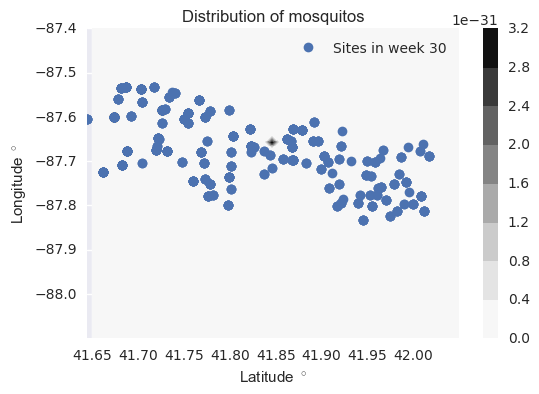

In [39]:
week = 30
inds = train['weeks_since_start']==week
Y,X = np.meshgrid(np.linspace(-88.1,-87.4),np.linspace(41.65,42.05))
week_num = 25*np.ones(X.size)
xy = np.vstack([Y.ravel(), X.ravel(),week_num]).T
predictions = gpr.predict(xy).reshape(X.shape)
Xp = train[inds][['Longitude','Latitude']].get_values()

plt.contourf(X,Y,predictions);
plt.plot(Xp[:,1],Xp[:,0],'o',label='Sites in week {}'.format(week));
plt.legend();
plt.title('Distribution of mosquitos');
plt.xlabel('Latitude $^\circ$');
plt.ylabel('Longitude $^\circ$');
plt.colorbar();

### Train on geographic location only

In [10]:
week = 25
inds = train['weeks_since_start']==week
X = train[inds][['Longitude','Latitude']].get_values()
y = data['num_mosquitoes'][inds]
gpr = GaussianProcessRegressor(kernel=kernels.Matern(length_scale=0.1))
gpr.fit(X,y)

//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-1769472.]), 'nit': 3, 'funcalls': 84}
  " state: %s" % convergence_dict)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=Matern(length_scale=0.1, nu=1.5),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

### Plot estimated number of mosquitoes at a given geographic location

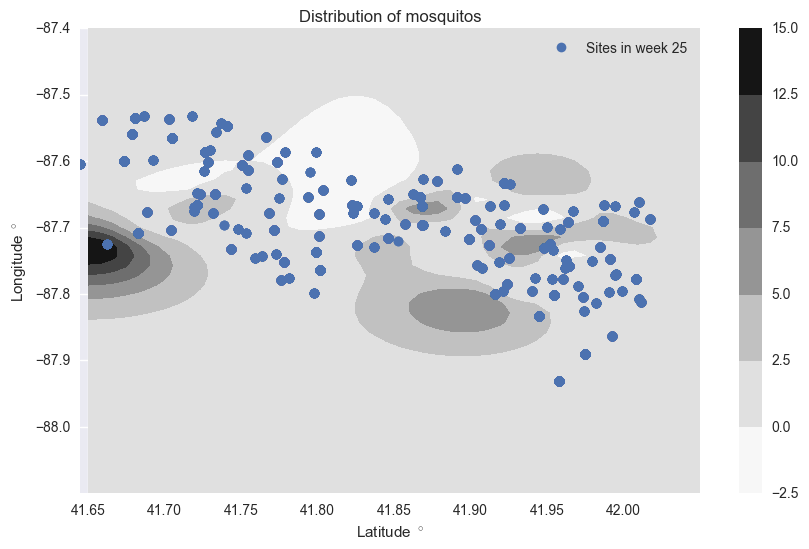

In [11]:
Y,X = np.meshgrid(np.linspace(-88.1,-87.4),np.linspace(41.65,42.05))
xy = np.vstack([Y.ravel(), X.ravel()]).T
predictions = gpr.predict(xy).reshape(X.shape)
Xp = train[['Longitude','Latitude']].get_values()

plt.figure(figsize=(10,6));
plt.contourf(X,Y,predictions);
plt.plot(Xp[:,1],Xp[:,0],'o',label='Sites in week {}'.format(week));
plt.legend();
plt.title('Distribution of mosquitos');
plt.xlabel('Latitude $^\circ$');
plt.ylabel('Longitude $^\circ$');
plt.colorbar();

# Create training validation set

Before submitting our predictions to Kaggle we want to be able to check how well they perform on data that hasn't been directly observed by the model, but ones for which we know the presence of WNV. To accomplish this we split the training dataset where we already know the labels into a dataset which we train the model on and one where we test how well the model is performing. Remember that for this competition the test/train datasets are split by season as below:

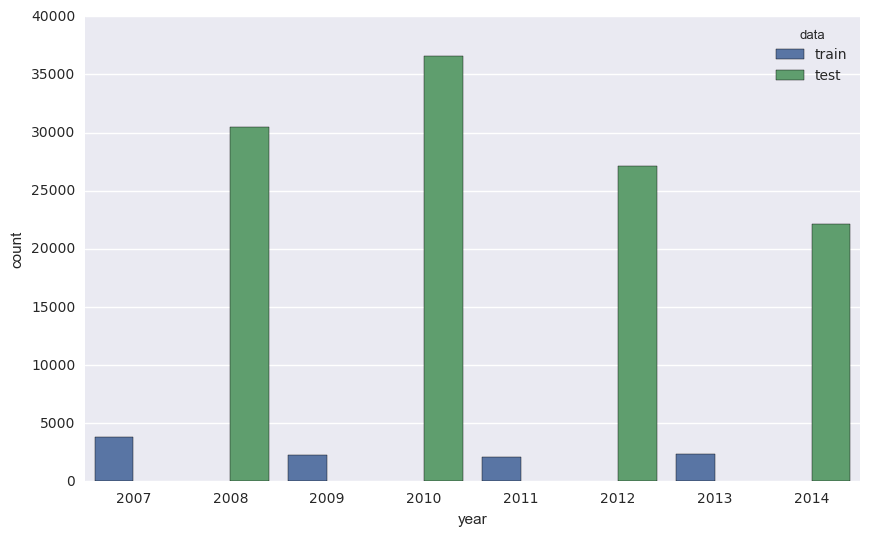

In [79]:
years = pd.DataFrame({'year' : train['year'],'data': len(train.index)*['train']})
years = years.append(pd.DataFrame({'year' : test['year'],'data': len(test.index)*['test']}),ignore_index=True)
plt.figure(figsize=(10,6));
sns.countplot(x="year",hue='data', data=years);

In order to construct a train/test split that is indicative of how the data is actually split in the competition we remove one season from the training set and try and predict on that missing season. The function below does this for a given season indexed from 0 to 3.

In [12]:
def createTrainValidationSplit(data,season=0):
    train = data['train']
    labels = data['labels']
    
    year = train['year'].unique()[season]

    
    Xtrain = train[train['year']==year].get_values()
    ytrain = labels[train['year']==year]
    
    Xtest = train[train['year']!=year].get_values()
    ytest = labels[train['year']!=year]
    return Xtrain,Xtest,ytrain,ytest

In [13]:
Xtrain,Xtest,ytrain,ytest = createTrainValidationSplit(data,season=0)

# Predictions

Now we have some features and a good way of splitting the data we can explore some models to predict the prevalence of WNV. First lets set-up a way of plotting the [AUC](https://www.kaggle.com/wiki/ROC) for a model (the method used to evaluated the competition) and also a way of performing [Kfolds cross-validation](https://en.wikipedia.org/wiki/Cross-validation_&#40statistics&#41#k-fold_cross-validation) for a given model.

In [6]:
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

def plotAUC(feature,true_label):
    #false positive rate, true positive rate
    fpr, tpr, _ = roc_curve(true_label,feature)
    #Receiver Operator Curve, Area Under Curve
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,6));
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc);
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.legend(loc="lower right");

def KFoldsTrain(modelName,data,**kwargs):
    plt.figure(figsize=(10,6));
    for season in tqdm(range(4)):
        Xtrain,Xtest,ytrain,ytest = createTrainValidationSplit(data,season=season)
        model = modelName(**kwargs)
        model.fit(Xtrain, ytrain)
        preds = model.predict_proba(Xtest)[:,1]
        #false positive rate, true positive rate
        fpr, tpr, _ = roc_curve(ytest,preds)
        #Receiver Operator Curve, Area Under Curve
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,
             lw=2, label='Season: {}, ROC curve (area = {:.2f})'.format(season,roc_auc));
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.legend(loc="lower right");
        
        

## 1. Logistic Regression
As a sanity check of our features we'll begin with one of the simplest possible models: a logistic regression

### Apply to one season

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
logreg = LogisticRegression(C=1e5)
logreg.fit(Xtrain, ytrain)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [9]:
preds = logreg.predict_proba(Xtest)[:,1]

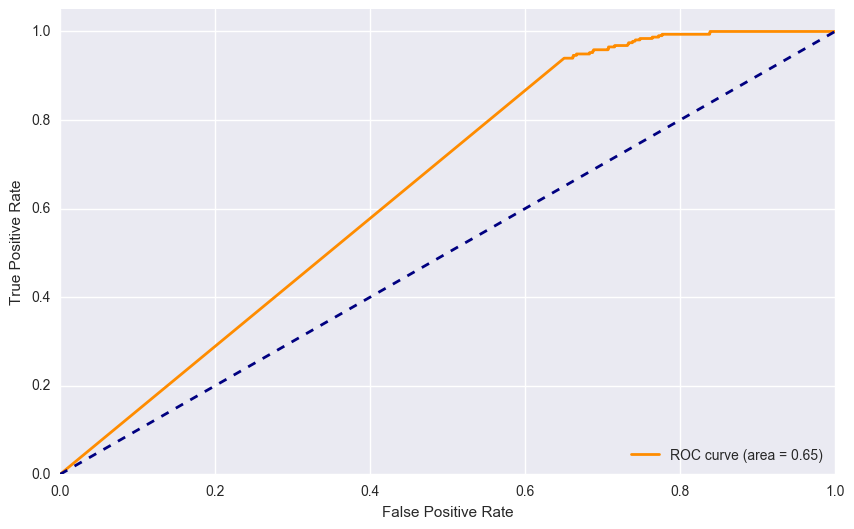

In [10]:
plotAUC(preds,ytest)

### Print most important features from highest to lowest

In [11]:
for s,c in sorted(zip(np.exp(logreg.coef_[0]),data['train'].columns),reverse=True):
    print("{} : {}".format(c,s))

PrecipTotal_y : 1.57303488387
Lat_int : 1.33874608809
weeks_since_start : 1.33726286817
Tavg_y : 1.30466598633
Cool_y : 1.22954231737
ResultDir_x : 1.2101717293
ResultSpeed_y : 1.20636363281
DewPoint_x : 1.18241652198
AvgSpeed_y : 1.10922346559
Tmax_y : 1.08710216558
WetBulb_x : 1.08256488482
month : 1.07975867496
day : 1.07599765239
Sunrise_x : 1.05781268317
AvgSpeed_x : 1.04854117104
Tavg_x : 1.04194545587
Sunset_x : 1.04181229351
StnPressure_y : 1.02537297286
StnPressure_x : 1.02312256685
SeaLevel_y : 1.02181550099
SeaLevel_x : 1.01986462254
Latitude : 1.01511860104
DateCount : 1.00506445298
Long_int : 1.0036942406
Block : 1.00345160612
SnowFall_x : 1.0
Depth_x : 1.0
Street : 0.996084125089
Trap : 0.994340581208
AddressAccuracy : 0.990112930881
Cool_x : 0.973539297869
Tmin_x : 0.963414620385
Tmin_y : 0.960357530752
WetBulb_y : 0.952327830995
Heat_y : 0.939826460203
Heat_x : 0.931777093581
year : 0.918452325988
PrecipTotal_x : 0.882610039426
Tmax_x : 0.832632618065
DewPoint_y : 0.810

### Perform K-folds validation

100%|██████████| 4/4 [00:00<00:00,  6.91it/s]


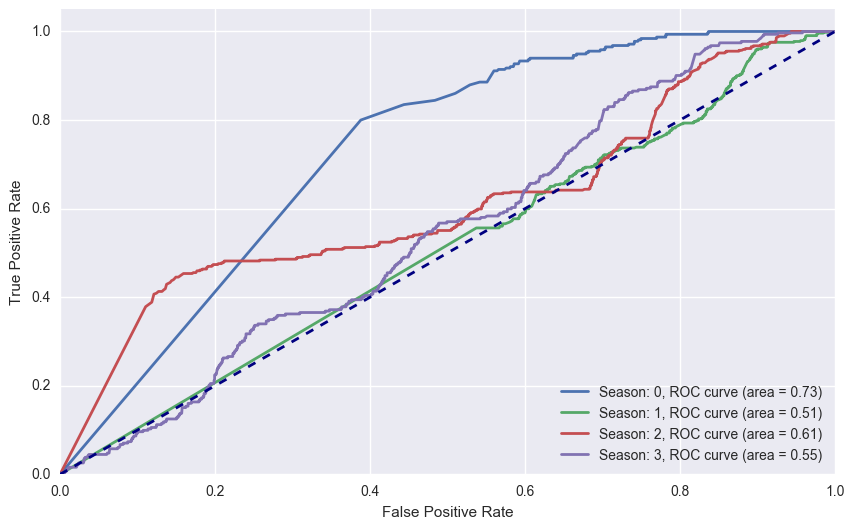

In [12]:
KFoldsTrain(LogisticRegression,data,C=1e5)

These results are pretty appalling. Can another model do better?

## 2. XG Boost
This is a boosted tree that tends to perform well in Kaggle competitions, often being part of the winning solution

In [13]:
from xgboost import XGBClassifier

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


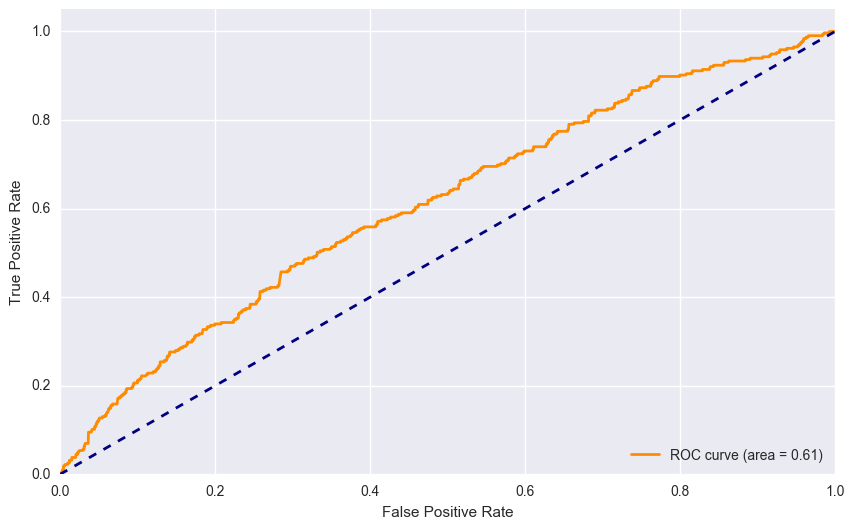

In [14]:
model = XGBClassifier()
model.fit(Xtrain, ytrain)
preds = model.predict_proba(Xtest)[:,1]
plotAUC(preds,ytest)

100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


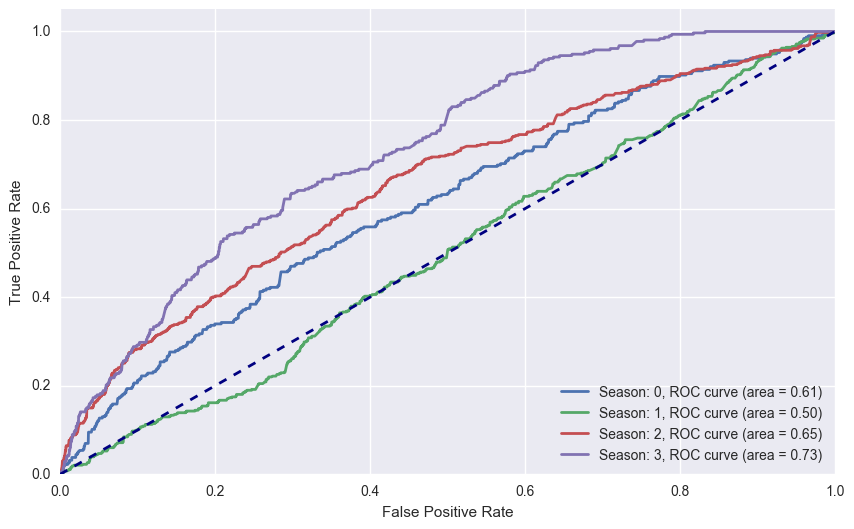

In [15]:
KFoldsTrain(XGBClassifier,data)

In [18]:
for s,c in sorted(zip(model.feature_importances_,data['train'].columns),reverse=True):
    print("{} : {}".format(c,s))

Longitude : 0.158894643188
weeks_since_start : 0.110535405576
Latitude : 0.10708117485
Street : 0.0915371328592
Trap : 0.0880829021335
Species : 0.0742659792304
Block : 0.0708117410541
Sunrise_x : 0.0466321259737
ResultSpeed_y : 0.0276338513941
AvgSpeed_y : 0.0276338513941
DewPoint_x : 0.0259067360312
Tmin_x : 0.0241796206683
PrecipTotal_x : 0.0241796206683
Tavg_x : 0.018998272717
ResultDir_y : 0.0155440410599
Tmax_x : 0.0120898103341
PrecipTotal_y : 0.0120898103341
AddressAccuracy : 0.0120898103341
Tmin_y : 0.00863557867706
DewPoint_y : 0.00863557867706
DateCount : 0.00863557867706
day : 0.00690846284851
ResultDir_x : 0.00518134701997
WetBulb_x : 0.00345423142426
AvgSpeed_x : 0.00345423142426
Tavg_y : 0.00172711571213
StnPressure_x : 0.00172711571213
ResultSpeed_x : 0.00172711571213
Depart_x : 0.00172711571213
year : 0.0
month : 0.0
WetBulb_y : 0.0
Tmax_y : 0.0
Sunset_x : 0.0
StnPressure_y : 0.0
SnowFall_x : 0.0
SeaLevel_y : 0.0
SeaLevel_x : 0.0
Long_int : 0.0
Lat_int : 0.0
Heat_y : 0

## 3. Data Augmentation

[Semi-supervised learning](https://en.wikipedia.org/wiki/Semi-supervised_learning) is a technique for incorporating in a larger amount of data than just the labelled data set. The idea is to expose the model to data in the test set by first fitting on the training set, predicting on the test set and then augmenting the training set with the predicted values. This can sometimes bias the model, but can also give a moderate boost in perfomance

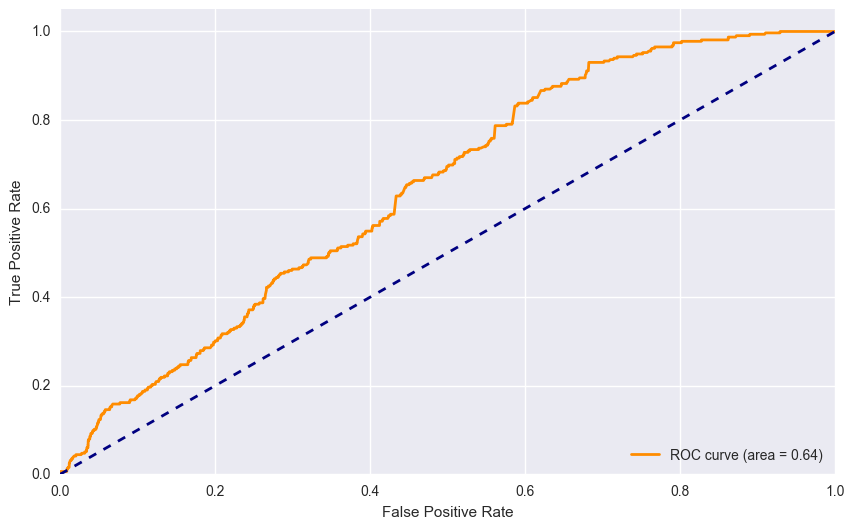

In [16]:
model = XGBClassifier()
model.fit(Xtrain, ytrain)
ytest_preds = model.predict(Xtest)
#Augment data
X = np.vstack((Xtest,Xtrain))
y = np.hstack((ytest_preds,ytrain))
model.fit(X, y)
preds = model.predict_proba(Xtest)[:,1]
plotAUC(preds,ytest)

In [17]:
def KFoldsTrainAugment(modelName,data,**kwargs):
    plt.figure(figsize=(10,6));
    for season in tqdm(range(4)):
        Xtrain,Xtest,ytrain,ytest = createTrainValidationSplit(data,season=season)
        model = modelName(**kwargs)
        model.fit(Xtrain, ytrain)
        ytest_preds = model.predict(Xtest)
        #Augment data
        X = np.vstack((Xtest,Xtrain))
        y = np.hstack((ytest_preds,ytrain))
        model = modelName(**kwargs)
        model.fit(X, y)
        
        #predict on augmented data
        preds = model.predict_proba(Xtest)[:,1]
        #false positive rate, true positive rate
        fpr, tpr, _ = roc_curve(ytest,preds)
        #Receiver Operator Curve, Area Under Curve
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,
             lw=2, label='Season: {}, ROC curve (area = {:.2f})'.format(season,roc_auc));
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.legend(loc="lower right");

100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


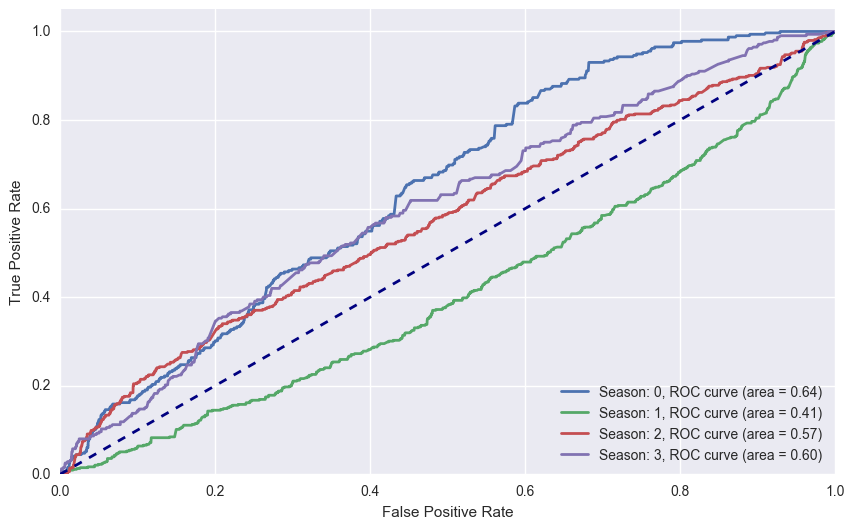

In [18]:
KFoldsTrainAugment(XGBClassifier,data)

## 4. Neural network classification

In [19]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

Using TensorFlow backend.


In [31]:
input_dim = Xtrain.shape[1]
Ytrain = np_utils.to_categorical(ytrain)
Ytest = np_utils.to_categorical(ytest)

In [35]:
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, kernel_initializer='random_uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(32, kernel_initializer='random_uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(32, kernel_initializer='random_uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2, kernel_initializer='random_uniform'))

    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [36]:
model = build_model(input_dim)

In [37]:
model.fit(Xtrain, Ytrain, epochs=20, batch_size=32, validation_data=(Xtest, Ytest), 
          verbose=True)
preds = model.predict_proba(Xtest)

Train on 3811 samples, validate on 6695 samples
Epoch 1/20
3811/3811 [==============================] - 1s - loss: 0.3036 - acc: 0.9331 - val_loss: 0.2738 - val_acc: 0.9529
Epoch 2/20
3811/3811 [==============================] - 0s - loss: 0.2781 - acc: 0.9381 - val_loss: 0.2703 - val_acc: 0.9529
Epoch 3/20
3811/3811 [==============================] - 0s - loss: 0.2696 - acc: 0.9381 - val_loss: 0.2141 - val_acc: 0.9529
Epoch 4/20
3811/3811 [==============================] - 0s - loss: 0.2720 - acc: 0.9381 - val_loss: 0.3116 - val_acc: 0.9529
Epoch 5/20
3811/3811 [==============================] - 0s - loss: 0.2690 - acc: 0.9381 - val_loss: 0.2369 - val_acc: 0.9529
Epoch 6/20
3811/3811 [==============================] - 0s - loss: 0.2584 - acc: 0.9381 - val_loss: 0.2977 - val_acc: 0.9529
Epoch 7/20
3811/3811 [==============================] - 0s - loss: 0.2561 - acc: 0.9381 - val_loss: 0.2596 - val_acc: 0.9529
Epoch 8/20
3811/3811 [==============================] - 0s - loss: 0.2516 - a

In [39]:
preds = preds[:,1]

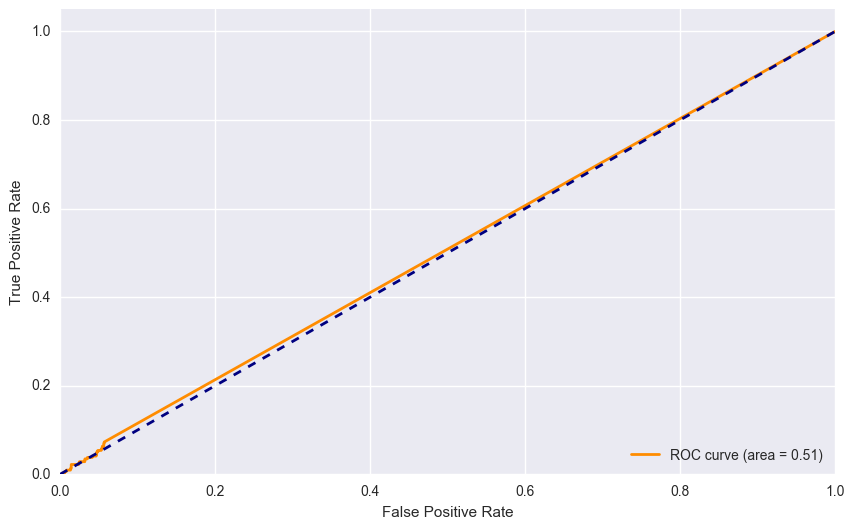

In [40]:
plotAUC(preds,ytest)

  0%|          | 0/4 [00:00<?, ?it/s]

5760/6695 [========================>.....] - ETA: 0s

 25%|██▌       | 1/4 [00:22<01:06, 22.06s/it]

8064/8257 [============================>.] - ETA: 0s

 50%|█████     | 2/4 [00:41<00:41, 20.69s/it]

7872/8452 [==========================>...] - ETA: 0s

 75%|███████▌  | 3/4 [00:59<00:19, 19.67s/it]

8032/8114 [============================>.] - ETA: 0s

100%|██████████| 4/4 [01:21<00:00, 20.28s/it]


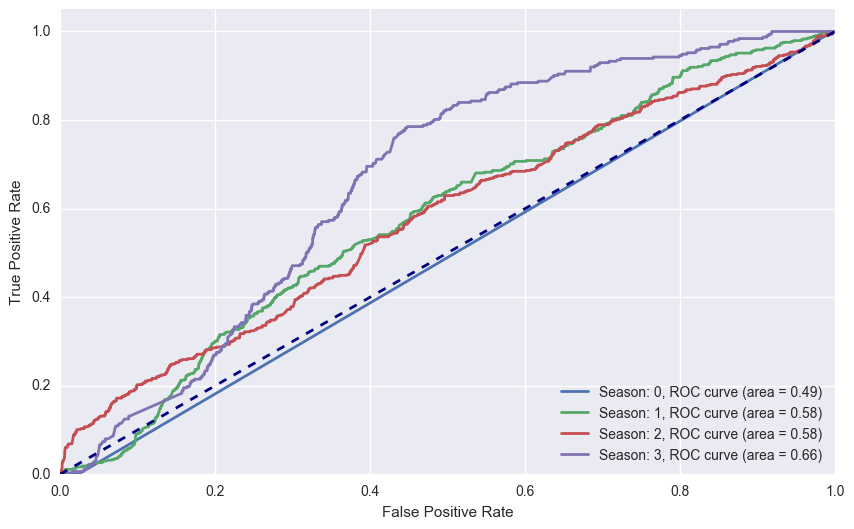

In [42]:
plt.figure(figsize=(10,6));
for season in tqdm(range(4)):
    Xtrain,Xtest,ytrain,ytest = createTrainValidationSplit(data,season=season)
    input_dim = Xtrain.shape[1]
    Ytrain = np_utils.to_categorical(ytrain)
    Ytest = np_utils.to_categorical(ytest)

    model = build_model(input_dim)
    model.fit(Xtrain, Ytrain, epochs=30, batch_size=32, validation_data=(Xtest, Ytest), 
              verbose=False)
    preds = model.predict_proba(Xtest)[:,1]
    
    #false positive rate, true positive rate
    fpr, tpr, _ = roc_curve(ytest,preds)
    #Receiver Operator Curve, Area Under Curve
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
         lw=2, label='Season: {}, ROC curve (area = {:.2f})'.format(season,roc_auc));
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.legend(loc="lower right");

Once again season 0 is predicted fairly poorly with season 3 doing the best job. The scores, however, are no better than xgb.